In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

In [2]:
def datestr2sec(date):
    secs = [3600,60,1]
    return sum([secs[i]*float(el) for i,el in enumerate(date.split(':'))])

def sec2datestr(seconds):
    secs = [3600, 60, 1]
    hours = int(seconds // secs[0])
    seconds = seconds % secs[0]
    mins = int(seconds // secs[1])
    seconds = seconds % secs[1]
    return str(hours)+':'+str(mins)+':'+str(int(seconds))

print(datestr2sec(sec2datestr(12)))
print(datestr2sec('00:01:23'))

12.0
83.0


Gamma:  0.0
Mean travel time:  1691.2983836644198 , formatted:  0:28:11
ratio of successfull trips:  0.8709794218816004
Average wait time:  985.6716095266991
Pt in trip ratio:  1.0
-------

Gamma:  0.7
Mean travel time:  1677.970220988038 , formatted:  0:27:57
ratio of successfull trips:  0.8878850315094355
Average wait time:  981.2608208641757
Pt in trip ratio:  0.9858144321889079
-------

Gamma:  1.4
Mean travel time:  1639.856193657963 , formatted:  0:27:19
ratio of successfull trips:  0.9237997534418994
Average wait time:  960.4865418452515
Pt in trip ratio:  0.9469008380148939
-------

Gamma:  2.8
Mean travel time:  1501.7962813186032 , formatted:  0:25:1
ratio of successfull trips:  0.9699647404674259
Average wait time:  833.2321207273878
Pt in trip ratio:  0.8157190724627377
-------

Gamma:  4.0
Mean travel time:  1403.5963893359458 , formatted:  0:23:23
ratio of successfull trips:  0.985611696854229
Average wait time:  722.8828586875011
Pt in trip ratio:  0.6642292351829823
---

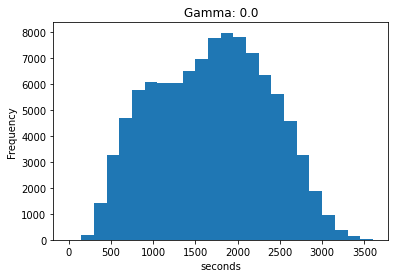

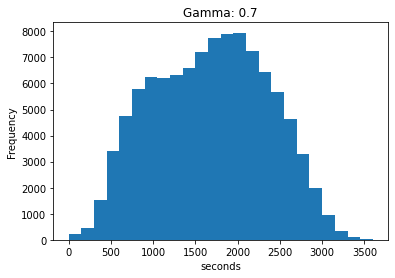

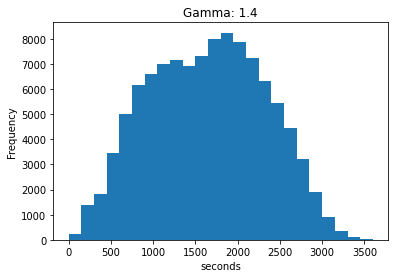

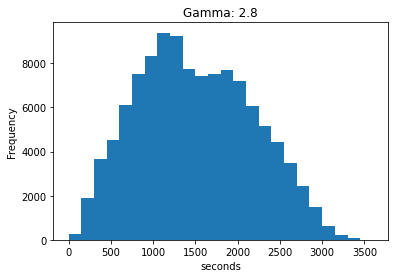

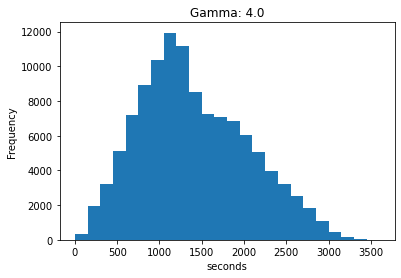

In [3]:
directory_bim = "/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/bim_10000trcap"
N_trips = 115997

def getTripTimes(directory):
    gammas = []
    trips = []
    drt_wait_times = []
    
    for root, subdirs, files in os.walk(directory):
        for file in files:
            if file == 'output_trips.csv.gz':
                request = re.match(".*gamma(\d*_\d*)", root)
                gammas.append(float(request.group(1).replace('_', '.')))
                df = pd.read_csv(os.path.join(root, file), sep=';', compression='gzip').loc[:,['person','trav_time','wait_time','modes']]
                df['trav_time'] = df['trav_time'].apply(datestr2sec)
                df['wait_time'] = df['wait_time'].apply(datestr2sec)
                df.set_index('person', inplace=True)
                trips.append(df)
            if file == '0.drt_trips_drt.csv':
                df = pd.read_csv(os.path.join(root, file), sep=';').loc[:,['personId','waitTime']]
                drt_wait_times.append(df.groupby('personId').sum())

    return np.array(gammas), trips, drt_wait_times
 

gammas, trip_dfs, drt_wait_times = getTripTimes(directory_bim)

for i,g in enumerate(gammas):
    print('Gamma: ', g)
    trip_dfs[i]['pure_trav_time'] = trip_dfs[i]['trav_time'] - trip_dfs[i]['wait_time']
    trip_dfs[i]['pure_trav_time'] = trip_dfs[i]['pure_trav_time'] + drt_wait_times[i]['waitTime']
    trip_dfs[i] = trip_dfs[i][trip_dfs[i]['pure_trav_time'] < 3600]
    mean_time = trip_dfs[i]['pure_trav_time'].mean()
    print('Mean travel time: ', mean_time, ', formatted: ', sec2datestr(mean_time))
    print('ratio of successfull trips: ', len(trip_dfs[i])/N_trips)
    print('Average wait time: ', drt_wait_times[i]['waitTime'].mean())
    mode_count = trip_dfs[i].groupby('modes').count()['trav_time']
    print('Pt in trip ratio: ', sum([count for key,count in mode_count.to_dict().items() if 'pt' in key])/mode_count.sum())
#     display(mode_count)
    plt.figure()
    trip_dfs[i]['pure_trav_time'].plot.hist(bins=24, range=(0, 3600))
    plt.xlabel('seconds')
    plt.title('Gamma: {}'.format(g))
    print('-------\n')

plt.show()

In [ ]:
directory_drt = "/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/drt/gammaInfty"

drt_df = pd.read_csv(os.path.join(directory_drt, 'output_trips.csv.gz'), sep=';', compression='gzip').loc[:,['person','trav_time','wait_time']]
drt_df['pure_trav_time'] = drt_df['trav_time'].apply(datestr2sec)# - drt_df['wait_time'].apply(datestr2sec)
drt_df.set_index('person', inplace=True)

# drt_df2 = pd.read_csv('/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/drt/gammaInfty/ITERS/it.0/0.drt_trips_drt.csv', sep=';').loc[:,['personId', 'waitTime', 'travelTime']]
# drt_df2 = drt_df2.groupby('personId').sum()
# drt_df['pure_trav_time'] = drt_df['pure_trav_time'] + drt_df2['waitTime']

print('ratio of successfull trips: ', len(drt_df)/N_trips)
print('Mean travel time: ', drt_df['pure_trav_time'].mean())
print('Mean wait time: ', drt_df['wait_time'].apply(datestr2sec).mean())

drt_df['pure_trav_time'].plot.hist(bins=24, range=(0, 3600))
plt.title(r'Gamma: $\infty$')
plt.show()

In [ ]:
mode_count = trip_dfs[0].groupby('modes').count()['trav_time']
print(mode_count)
print(sum([count for key,count in mode_count.to_dict().items() if 'drt' in key]))